In [30]:
from pydantic import BaseModel, ConfigDict, Field
import numpy as np
from itertools import product
from random import choices
import matplotlib.pyplot as plt


In [102]:
INIT_VEL = np.zeros(2, dtype=np.float32)
MAX_SPEED: np.float32 = np.float32(1)
MAX_FORCE: np.float32 = np.float32(0.5)

## Boids implementation

In [83]:
class Boid(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    position: np.ndarray
    velocity: np.ndarray

class Swarm:
    def __init__(self, n: int, x_max: int, y_max: int) -> list[Boid]:
        xs, ys = np.meshgrid(np.arange(x_max, dtype=np.float32), np.arange(y_max, dtype=np.float32))
        pairs = np.column_stack((xs.ravel(), ys.ravel()))
        idxs = np.random.choice(x_max * y_max, size=n, replace=False)
        self._swarm =  [Boid(position=pairs[i], velocity=INIT_VEL) for i in idxs]
        self.x_limits = (0.0, x_max)
        self.y_limits = (0.0, y_max)

    @staticmethod
    def in_radius(x: Boid, y: Boid, r: float):
        return np.sqrt(np.sum((x.position-y.position)**2)) <= r


    def _get_neighbours(self, target: Boid, radius: float) -> list[Boid]:
        neighbours: list[Boid] = []
        for boid in self._swarm:
            if Swarm.in_radius(target, boid, radius) and boid is not target:
                neighbours.append(boid)
        return neighbours
    

    def update_pos(self, rules: "Rules",  max_speed=MAX_SPEED):
        self._update_vel(rules, max_speed)
        for boid in self._swarm:
            boid.position += boid.velocity
            if boid.position[0] < self.x_limits[0] or boid.position[0] > self.x_limits[1]:
                boid.velocity[0] *= -1
                boid.position[0] = np.clip(boid.position[0], *self.x_limits)
            if boid.position[1] < self.y_limits[0] or boid.position[1] > self.y_limits[1]:
                boid.velocity[1] *= -1
                boid.position[1] = np.clip(boid.position[1], *self.y_limits)
        
    def _update_vel(self, rules: "Rules", max_speed=MAX_SPEED):
        for boid, acc in zip(self._swarm, self.get_acc(rules)):
            boid.velocity += acc
            speed = np.linalg.norm(boid.velocity)
            if speed > max_speed:
                boid.velocity = boid.velocity / speed * max_speed

    def get_acc(self, rules) -> list[np.ndarray]:
        accs = []
        for boid in self._swarm:
            sep = self._compute_sepataion(boid, rules.rs, rules.ws)
            ali = self._compute_allignment(boid, rules.ra, rules.wa)
            coh = self._compute_coheison(boid, rules.rc, rules.wc)
            acc = sep + ali + coh
            accs.append(acc)
        return accs
    
    def _compute_sepataion(self, target: Boid, rs: float, ws: float) -> np.float32:
        neighbours = self._get_neighbours(target, rs)
        if len(neighbours) == 0:
            return  np.zeros(2, dtype=np.float32)
        neighbours_pos = np.array([b.position for b in neighbours])
        direction_away = target.position - neighbours_pos
        dist = np.linalg.norm(direction_away, axis=1)
        sep = direction_away / dist[:, None]
        return np.sum(sep, axis=0) * ws

    def _compute_allignment(self, target: Boid, ra: float, wa: float) -> np.float32:
        neighbours = self._get_neighbours(target, ra)
        if len(neighbours) == 0:
            return  np.zeros(2, dtype=np.float32)
        neighbours_vel = np.array([b.velocity for b in neighbours])
        avg_vel = np.mean(neighbours_vel, axis=0)
        return (avg_vel - target.velocity) * wa

    def _compute_coheison(self, target: Boid, rc: float, wc: float) -> np.float32:
        neighbours = self._get_neighbours(target, rc)
        if len(neighbours) == 0:
            return  np.zeros(2, dtype=np.float32)
        neighbours_pos = np.array([b.position for b in neighbours])
        center = np.mean(neighbours_pos, axis=0)
        return (center - target.position) * wc


class Rules(BaseModel):
    rs: float = Field(description="radius for separation")
    ws: float = Field(description="weight for separation")
    ra: float = Field(description="radius for alignment")
    wa: float = Field(description="weight for alignment")
    rc: float = Field(description="radius for cohesion")
    wc: float = Field(description="weight for cohesion")

    

class World:
    def __init__(self, size: int) -> None:
        self._size = size
        self._boids: list[Boid] = []
        self._rules: Rules | None = None

    def set_swarm(self, swarm: list[Boid]) -> None:
        self._boids = swarm

    def set_rules(self, rules: Rules) -> None:
        self._rules = rules

    def step(self):
        accs = self._swarm.update_acc(self._rules)
        self._swarm.update_pos(accs)

    def draw(self):
        xs = [b.position[0] for b in self._boids]
        ys = [b.position[1] for b in self._boids]

        plt.scatter(xs, ys)
        plt.xlim(0, self._size)
        plt.ylim(0, self._size)
        plt.show()

In [95]:
class World:
    def __init__(self, size: float, swarm: Swarm, rules: Rules) -> None:
        self._size = size
        self._swarm = swarm
        self._rules = rules

    def step(self):
        self._swarm.update_pos(self._rules)

    def draw(self):
        xs = [b.position[0] for b in self._swarm._swarm]
        ys = [b.position[1] for b in self._swarm._swarm]
        plt.scatter(xs, ys, color="blue", s=50)
        plt.xlim(0, self._size)
        plt.ylim(0, self._size)
        plt.show()

    def animate(self, frames: int = 200, interval: int = 50, save_path: str | None = None):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlim(0, self._size)
        ax.set_ylim(0, self._size)
        ax.set_xticks([])
        ax.set_yticks([])

        xs = [b.position[0] for b in self._swarm._swarm]
        ys = [b.position[1] for b in self._swarm._swarm]
        scat = ax.scatter(xs, ys, s=40)

        def update(frame):
            self.step()
            xs = [b.position[0] for b in self._swarm._swarm]
            ys = [b.position[1] for b in self._swarm._swarm]
            scat.set_offsets(list(zip(xs, ys)))
            ax.set_title(f"Boids — frame {frame+1}")
            return scat,

        anim = animation.FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
        
        if save_path is not None:
            writer = animation.PillowWriter(fps=15)
            anim.save(save_path, writer=writer, dpi=150)
            print(f"Saved animation to {save_path}")
        else:
            plt.show()

Saved animation to boids.gif


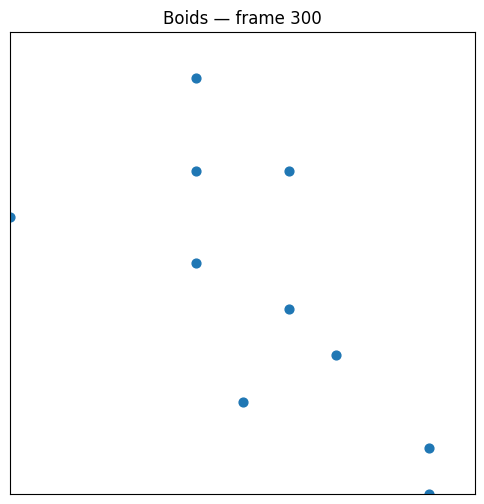

In [ ]:
swarm = Swarm(n=10, x_max=10, y_max=10)
# for b in swarm._swarm:
    # b.velocity = np.random.rand(2) * 1 - 0.5
rules = Rules(
    rs=0.0, ws=0.02,
    ra=0.0, wa=0.0,
    rc=5.0, wc=1.000,
)
world = World(size=10, swarm=swarm, rules=rules)
world.animate(frames=300, interval=50, save_path="boids.gif")


In [105]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import os

rng = np.random.default_rng(42)
# Simulation parameters (tweak as needed)
N = 60                # number of boids
width, height = 10.0, 10.0
max_speed = 2.0
max_force = 0.05
neighbor_radius = 1.0
separation_radius = 0.25

# Behavior weights
w_align = 0.0
w_cohesion = 0.8
w_separation = 0.0

dt = 0.1
frames = 240

# Initialize positions and velocities
pos = np.random.rand(N, 2) * np.array([width, height])
angles = np.random.rand(N) * 2 * np.pi
vel = np.column_stack((np.cos(angles), np.sin(angles))) * (0.5 + np.random.rand(N) * 1.0)[:, None]

def limit_vector(v, max_val):
    norm = np.linalg.norm(v)
    if norm > max_val and norm > 0:
        return v / norm * max_val
    return v

def compute_accelerations(pos, vel):
    acc = np.zeros_like(pos)
    for i in range(N):
        p_i = pos[i]
        v_i = vel[i]

        # Differences with wrapping (toroidal)
        diff = pos - p_i
        diff[:,0] = (diff[:,0] + width/2) % width - width/2
        diff[:,1] = (diff[:,1] + height/2) % height - height/2
        dists = np.linalg.norm(diff, axis=1)

        neighbors = (dists > 0) & (dists < neighbor_radius)
        sep_neighbors = (dists > 0) & (dists < separation_radius)

        # Alignment
        if np.any(neighbors):
            avg_vel = vel[neighbors].mean(axis=0)
            steer_align = avg_vel - v_i
            steer_align = limit_vector(steer_align, max_force)
        else:
            steer_align = np.zeros(2)

        # Cohesion
        if np.any(neighbors):
            center_offset = diff[neighbors].mean(axis=0)
            center = p_i + center_offset
            desired = center - p_i
            steer_cohesion = desired - v_i
            steer_cohesion = limit_vector(steer_cohesion, max_force)
        else:
            steer_cohesion = np.zeros(2)

        # Separation
        steer_separation = np.zeros(2)
        if np.any(sep_neighbors):
            close = diff[sep_neighbors]
            close_d = dists[sep_neighbors][:, None]
            push = -np.sum(close / (close_d**2 + 1e-6), axis=0)
            steer_separation = limit_vector(push, max_force)

        # Combine
        force = (w_align * steer_align +
                 w_cohesion * steer_cohesion +
                 w_separation * steer_separation)
        acc[i] = force
    return acc

# Prepare figure
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(0, width); ax.set_ylim(0, height); ax.set_xticks([]); ax.set_yticks([])
scat = ax.scatter(pos[:,0], pos[:,1], s=40)
quiv = ax.quiver(pos[:,0], pos[:,1], vel[:,0], vel[:,1], angles='xy', scale_units='xy', scale=1.5)

def step():
    global pos, vel
    acc = compute_accelerations(pos, vel)
    vel = vel + acc * dt
    speeds = np.linalg.norm(vel, axis=1)
    for i in range(N):
        if speeds[i] > max_speed:
            vel[i] = vel[i] / speeds[i] * max_speed
    pos = (pos + vel * dt) % np.array([width, height])

def update(frame):
    step()
    scat.set_offsets(pos)
    quiv.set_offsets(pos)
    quiv.set_UVC(vel[:,0], vel[:,1])
    ax.set_title(f"Boids — frame {frame+1}/{frames}")
    return scat, quiv

# Output directory
outdir = "boids_output"
os.makedirs(outdir, exist_ok=True)

# Save a few static frames by running the sim in a separate copy of the state
save_frames_idx = [0, 80, 160]
pos_save = pos.copy()
vel_save = vel.copy()
fig2, ax2 = plt.subplots(figsize=(6,6))
for i in range(max(save_frames_idx)+1):
    if i in save_frames_idx:
        ax2.clear()
        ax2.set_xlim(0, width); ax2.set_ylim(0, height); ax2.set_xticks([]); ax2.set_yticks([])
        ax2.scatter(pos_save[:,0], pos_save[:,1], s=40)
        ax2.quiver(pos_save[:,0], pos_save[:,1], vel_save[:,0], vel_save[:,1], angles='xy', scale_units='xy', scale=1.5)
        path = os.path.join(outdir, f"static_frame_{i:03d}.png")
        fig2.savefig(path, dpi=150, bbox_inches='tight')
    # advance
    acc_s = compute_accelerations(pos_save, vel_save)
    vel_save = vel_save + acc_s * dt
    speeds = np.linalg.norm(vel_save, axis=1)
    for k in range(N):
        if speeds[k] > max_speed:
            vel_save[k] = vel_save[k] / speeds[k] * max_speed
    pos_save = (pos_save + vel_save * dt) % np.array([width, height])
plt.close(fig2)

# Create animation
anim = animation.FuncAnimation(fig, update, frames=frames, interval=33, blit=False)

# Save GIF
gif_path = os.path.join(outdir, "boids.gif")
print("Saving GIF to:", gif_path)
writer = PillowWriter(fps=30)
anim.save(gif_path, writer=writer, dpi=150)

# Optional MP4 (requires ffmpeg)
mp4_path = os.path.join(outdir, "boids.mp4")
try:
    anim.save(mp4_path, fps=30, dpi=150)
    print("Saved MP4 to:", mp4_path)
except Exception as e:
    print("MP4 save failed (ffmpeg may be missing). Error:", e)

plt.close(fig)
print("Files created in", outdir)
print(os.listdir(outdir))


Saving GIF to: boids_output/boids.gif
Saved MP4 to: boids_output/boids.mp4
Files created in boids_output
['static_frame_160.png', 'static_frame_080.png', 'boids.gif', 'boids.mp4', 'static_frame_000.png']


In [ ]:
x = BoidsSwarm(10)
x.generate_population(100, 1.0)

ValidationError: 1 validation error for Boid
velocity
  Input should be an instance of float64 [type=is_instance_of, input_value=1.0, input_type=float]
    For further information visit https://errors.pydantic.dev/2.11/v/is_instance_of